In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, r2_score
from cmdstanpy import CmdStanModel
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
ABS_PATH = 'Bayesian-analysis-of-public-transport-passengers'

In [4]:
# Set random seed for reproducibility
np.random.seed(42)
# Load preprocessed data
train_data = pd.read_csv(os.path.join(ABS_PATH,'processed_train_data.csv'))
test_data = pd.read_csv(os.path.join(ABS_PATH,'processed_test_data.csv'))

# Check if data is empty
if len(train_data) == 0:
    raise ValueError("Train data is empty. Check preprocessing step.")
if len(test_data) == 0:
    print("Warning: Test data is empty. Predictions will be skipped.")

In [5]:
# Define features and target
categorical_cols = ['is_raining', 'day_of_week', 'month']
numerical_cols = [col for col in train_data.columns if col not in ['date', 'passenger_count', 'is_raining', 'day_of_week', 'month']]
features = numerical_cols + categorical_cols
target = 'passenger_count'

In [6]:
# Prepare training and test sets
X_train = train_data[features]
y_train = train_data[target]
X_test = test_data[features] if len(test_data) > 0 else pd.DataFrame(columns=X_train.columns)
y_test = test_data[target] if len(test_data) > 0 else pd.Series()

In [7]:
# Preprocess categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_cols),
        ('num', 'passthrough', numerical_cols)
    ])
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test) if len(X_test) > 0 else np.array([])

In [8]:
# Get feature names after encoding
cat_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols)
feature_names = list(cat_feature_names) + numerical_cols

# Prior

In [9]:
stan_data = {
    'N': len(X_train_transformed),
    'K': X_train_transformed.shape[1],
    'X': X_train_transformed,
}

In [10]:
# Compile and fit model
linear_regression = os.path.join(ABS_PATH, 'stan/linear_regression.stan')
model = CmdStanModel(stan_file=linear_regression)
prior_fit = model.sample(data=stan_data, chains=3, iter_sampling=600, iter_warmup=200, seed=42)

15:59:55 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

16:00:11 - cmdstanpy - INFO - CmdStan done processing.


In [11]:
# Extract samples from prior_fit
y_samples = prior_fit.stan_variable("y")

# Compute means
mean_y_train = np.mean(y_train) if len(y_train) > 0 else 0
mean_y_samples = np.mean(y_samples)

# Verify consistency
print(f"Mean of sampled y (prior predictive): {mean_y_samples:.3f}")
print(f"Mean of y_train (real passenger counts): {mean_y_train:.3f}")

Mean of sampled y (prior predictive): -0.016
Mean of y_train (real passenger counts): -0.000


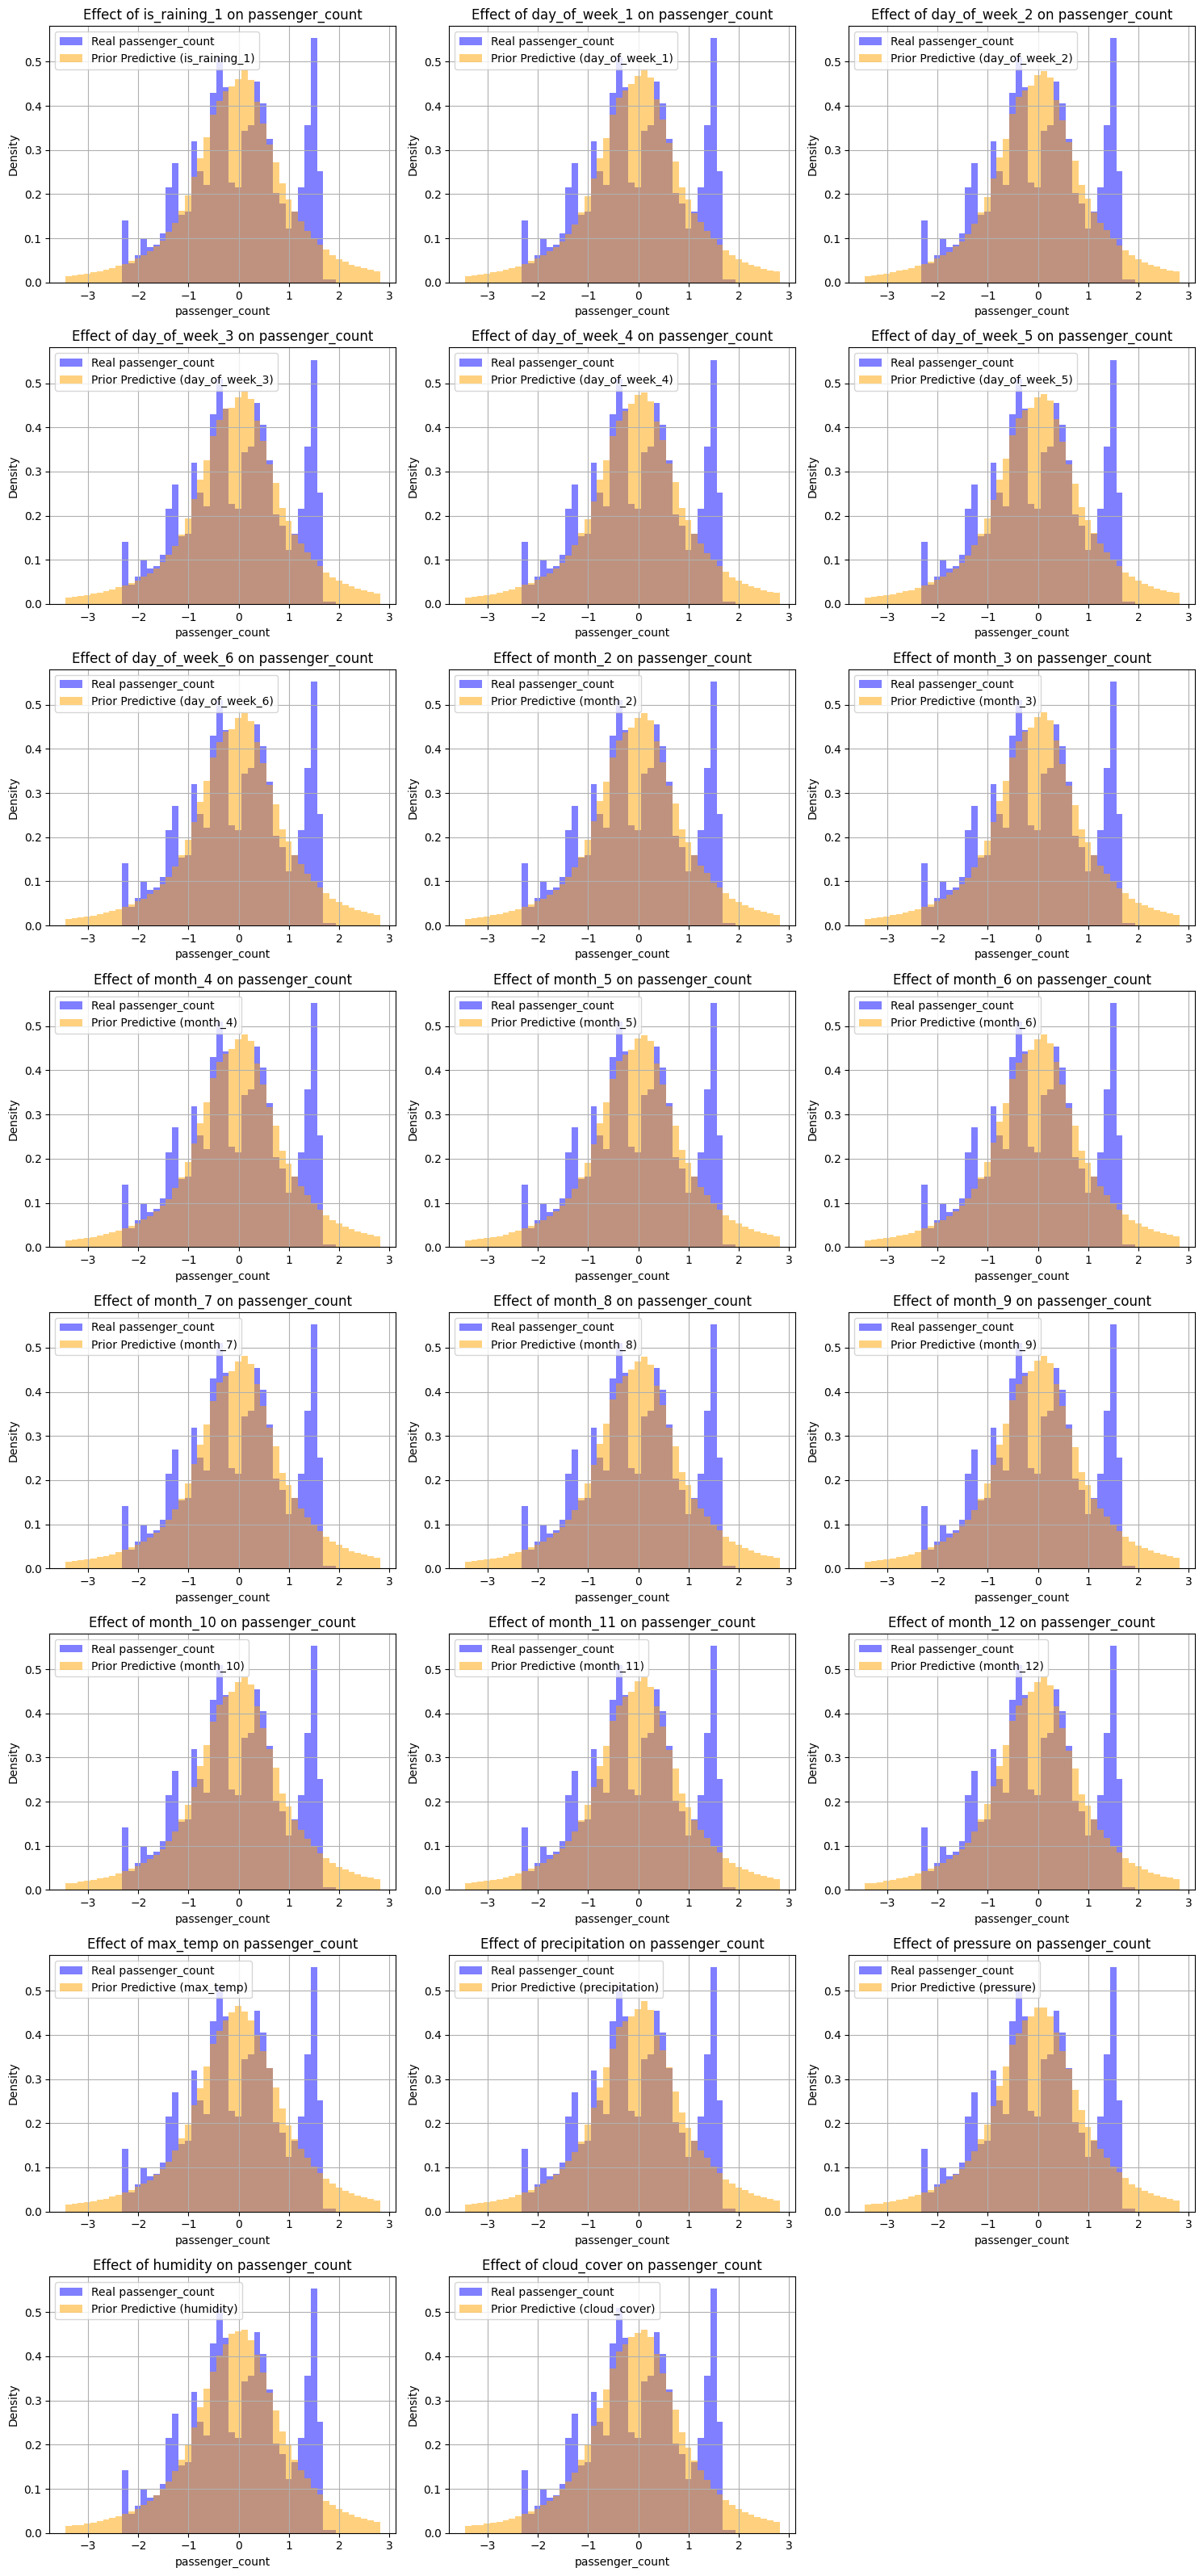

In [16]:
y_prior = prior_fit.stan_variable('y').flatten()
y_per_feature = prior_fit.stan_variable('y_per_feature')
real_data = y_train.values
n_features = len(feature_names)

# Prepare subplots
n_cols = min(n_features, 3)
n_rows = (n_features + n_cols - 1) // n_cols
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(5 * n_cols, 4 * n_rows))
axes = axes.flatten() if n_features > 1 else [axes]

bin_range = (real_data.min() * 1.5, real_data.max() * 1.5)

# Plot for each feature
for idx, feature in enumerate(feature_names):
    y_feature = y_per_feature[:, idx, :].flatten()

    # Use 'auto' binning (or manually set bins if needed)
    axes[idx].hist(real_data, bins=50, density=True, alpha=0.5, label='Real passenger_count', color='blue', range=bin_range,
                   histtype='stepfilled')
    axes[idx].hist(y_feature, bins=50, density=True, alpha=0.5, label=f'Prior Predictive ({feature})', color='orange', range=bin_range,
                   histtype='stepfilled')

    axes[idx].set_title(f'Effect of {feature} on passenger_count')
    axes[idx].set_xlabel('passenger_count')
    axes[idx].set_ylabel('Density')
    axes[idx].legend()
    axes[idx].grid(True)

# Hide any unused subplots
for j in range(len(feature_names), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


In [16]:
# Compile and fit model
linear_regression_2 = os.path.join(ABS_PATH, 'stan/linear_regression_copy.stan')
model_2 = CmdStanModel(stan_file=linear_regression_2)
prior_fit_2 = model_2.sample(data=stan_data, chains=3, iter_sampling=600, iter_warmup=200, seed=42)

# Extract samples from prior_fit
y_samples_2 = prior_fit_2.stan_variable("y")

# Compute means
mean_y_samples_2 = np.mean(y_samples_2)

# Verify consistency
print(f"Mean of sampled y (prior predictive): {mean_y_samples_2:.3f}")
print(f"Mean of y_train (real passenger counts): {mean_y_train:.3f}")

15:57:28 - cmdstanpy - INFO - compiling stan file /workspace/Bayesian-analysis-of-public-transport-passengers/stan/linear_regression_copy.stan to exe file /workspace/Bayesian-analysis-of-public-transport-passengers/stan/linear_regression_copy
15:58:11 - cmdstanpy - INFO - compiled model executable: /workspace/Bayesian-analysis-of-public-transport-passengers/stan/linear_regression_copy
15:58:11 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

15:58:22 - cmdstanpy - INFO - CmdStan done processing.



Mean of sampled y (prior predictive): -0.027
Mean of y_train (real passenger counts): -0.000


In [ ]:
y_prior_2 = prior_fit_2.stan_variable('y').flatten()
y_per_feature_2 = prior_fit_2.stan_variable('y_per_feature')

# Plot for each feature
for idx, feature in enumerate(feature_names):
    y_feature_2 = y_per_feature_2[:, idx, :].flatten()

    # Use 'auto' binning (or manually set bins if needed)
    axes[idx].hist(real_data, bins='auto', density=True, alpha=0.5, label='Real passenger_count', color='blue', range=bin_range,
                   histtype='stepfilled')
    axes[idx].hist(y_feature_2, bins='auto', density=True, alpha=0.5, label=f'Prior Predictive ({feature})', color='orange', range=bin_range,
                   histtype='stepfilled')

    axes[idx].set_title(f'Effect of {feature} on passenger_count')
    axes[idx].set_xlabel('passenger_count')
    axes[idx].set_ylabel('Density')
    axes[idx].legend()
    axes[idx].grid(True)

# Hide any unused subplots
for j in range(len(feature_names), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


# Posterior

In [12]:
# Prepare data for Stan
fit_stan_data = {
    'N': len(X_train_transformed),
    'K': X_train_transformed.shape[1],
    'X': X_train_transformed,
    'y': y_train.values
}

In [13]:
# Compile and fit model
linear_regression = os.path.join(ABS_PATH, 'stan/linear_regression_fit.stan')
model = CmdStanModel(stan_file=linear_regression)
fit = model.sample(data=fit_stan_data, chains=3, iter_sampling=600, iter_warmup=200, seed=42)

12:37:25 - cmdstanpy - INFO - compiling stan file /workspace/Bayesian-analysis-of-public-transport-passengers/stan/linear_regression_fit.stan to exe file /workspace/Bayesian-analysis-of-public-transport-passengers/stan/linear_regression_fit
12:40:57 - cmdstanpy - INFO - compiled model executable: /workspace/Bayesian-analysis-of-public-transport-passengers/stan/linear_regression_fit
12:41:18 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

12:41:32 - cmdstanpy - INFO - CmdStan done processing.


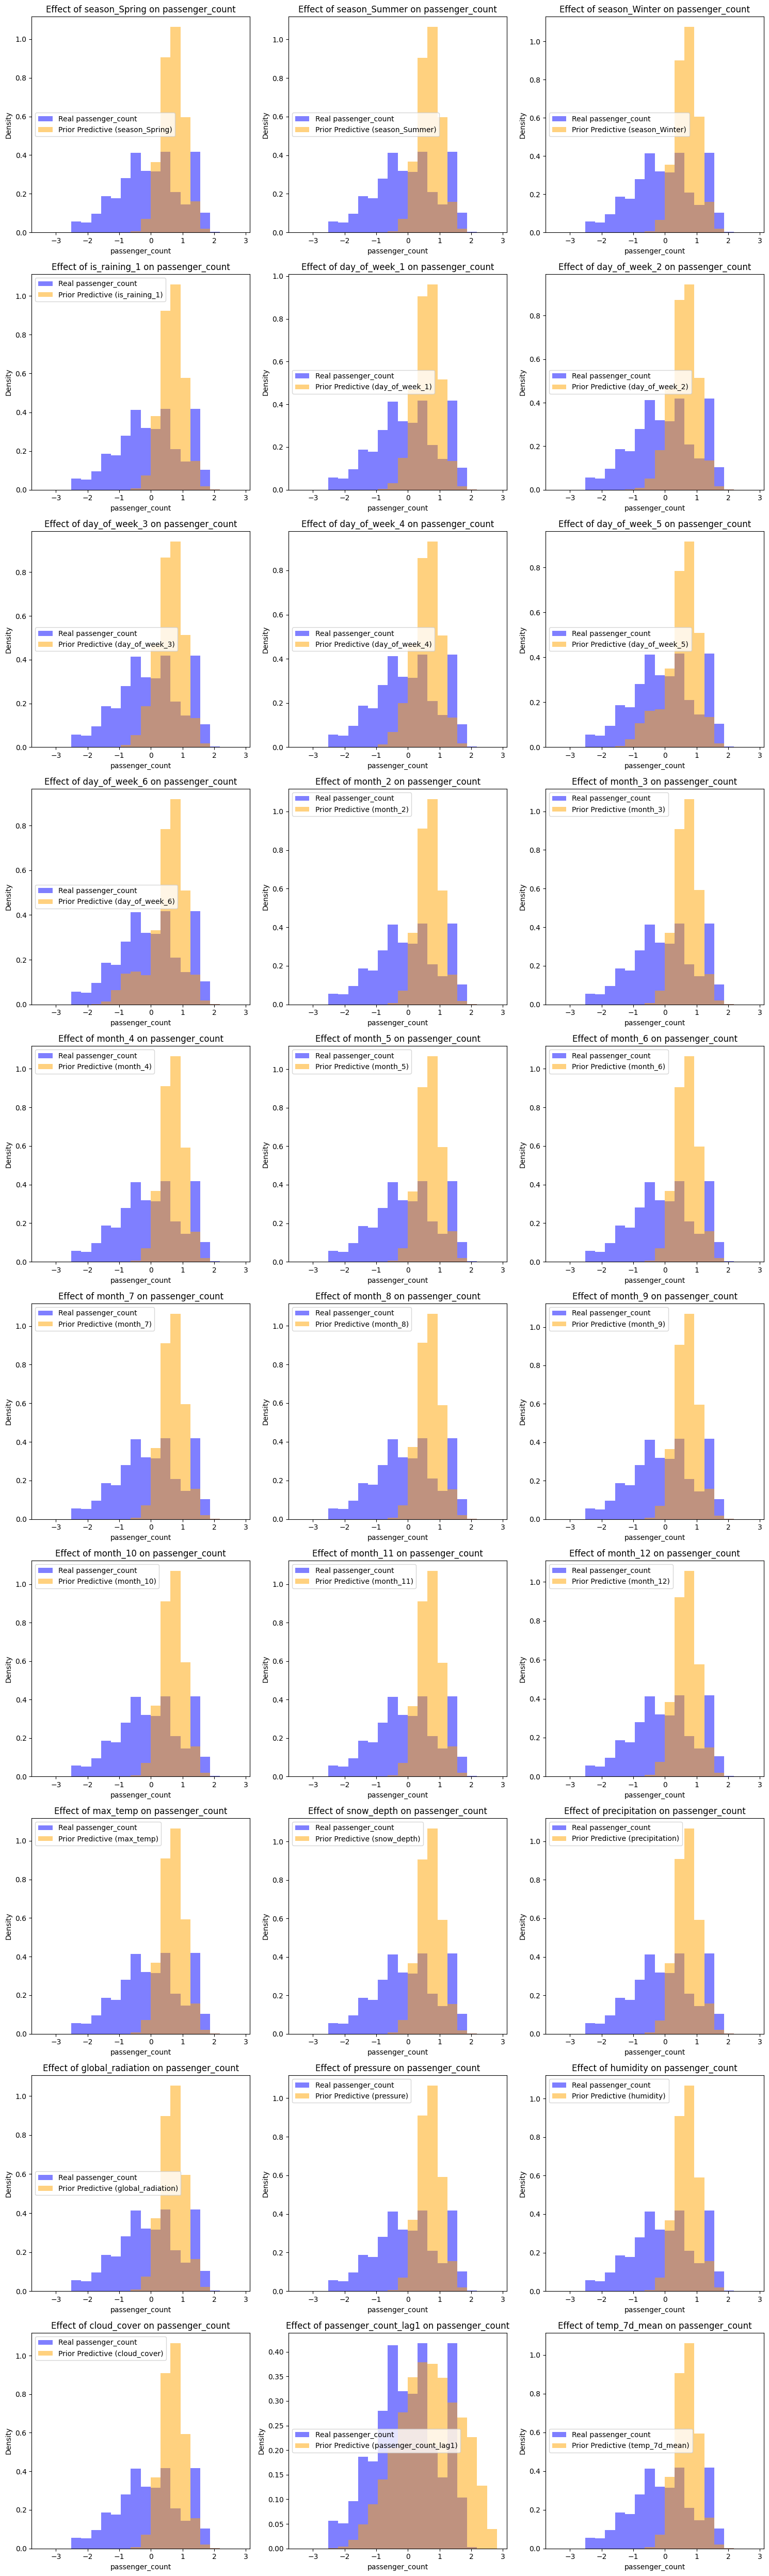

In [14]:
# Extract prior predictive samples
y = fit.stan_variable('y_pred').flatten()  # Shape: (n_samples * N,)
y_per_feature = fit.stan_variable('y_per_feature')  # Shape: (n_samples, K, N)
real_data = y_train.values

# Visualization: Histograms for real and prior predictive passenger_count for each feature
n_features = len(feature_names)
fig, axes = plt.subplots(nrows=(n_features + 2) // 3, ncols=min(n_features, 3), figsize=(15, 5 * ((n_features + 2) // 3)))
axes = axes.flatten() if n_features > 1 else [axes]
bin_range = (real_data.min()*1.5, real_data.max() * 1.5)
# Plot for each feature
for idx, feature in enumerate(feature_names):
    # Extract prior predictive samples for this feature (flatten across samples and observations)
    y_feature = y_per_feature[:, idx, :].flatten()  # Shape: (n_samples * N,)

    # Plot histograms with plt.hist
    axes[idx].hist(real_data, bins=20, density=True, alpha=0.5, label='Real passenger_count', color='blue', 
                   range=bin_range, histtype='stepfilled')
    axes[idx].hist(y_feature, bins=20, density=True, alpha=0.5, label=f'Prior Predictive ({feature})', color='orange', 
                   range=bin_range, histtype='stepfilled')
    
    axes[idx].set_title(f'Effect of {feature} on passenger_count')
    axes[idx].set_xlabel('passenger_count')
    axes[idx].set_ylabel('Density')
    axes[idx].legend()

# Adjust layout and display
plt.tight_layout()
plt.show()